In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf

from sklearn.datasets import make_moons, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

%matplotlib inline

# Sonar Dataset

In [3]:
X = pd.read_csv('/home/nareg/Desktop/Data Science/Deep Learning/sonar.all-data', header = None,
                usecols = range(0, 60))

y = pd.read_csv('/home/nareg/Desktop/Data Science/Deep Learning/sonar.all-data', header = None,
                usecols = [60])

In [4]:
print(X.shape)
X.head(3)

(208, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078


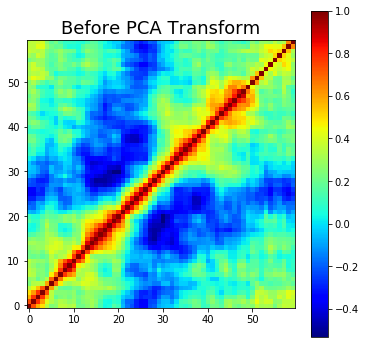

In [5]:
# Correlation matrix before PCA
plt.figure(figsize = (6, 6))

plt.imshow(X.corr().values, origin = 'lower', cmap = 'jet')

plt.title("Before PCA Transform", size = 18)
plt.colorbar();

In [6]:
pd.value_counts(y.values.ravel())

M    111
R     97
dtype: int64

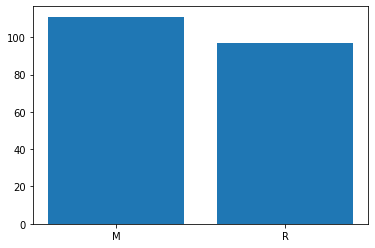

In [7]:
# Value count for each class
plt.bar(pd.value_counts(y.values.ravel()).index, pd.value_counts(y.values.ravel()));

In [8]:
# Perfom pca
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X), index = X.index)

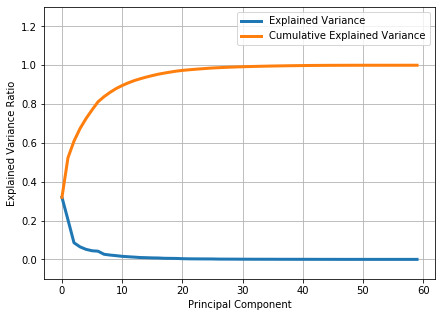

In [9]:
plt.figure(figsize = (7, 5))

plt.plot(pca.explained_variance_ratio_, lw = 3, label = 'Explained Variance')
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw = 3, label = 'Cumulative Explained Variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.ylim(-0.1, 1.3)
plt.grid();

In [10]:
# Where we pass 90% of variance explained
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.90)[0][0]

11

In [11]:
X_ = X_pca.iloc[:, 0:12]

# PCA transformed X data
print(X_.shape)
X_.head()

(208, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.576093,0.319393,-0.387291,-0.378009,-0.243780,-0.156243,-0.427736,0.074832,-0.024347,0.318054,0.115546,-0.191408
1,-0.970667,1.018039,0.834156,0.107423,0.286070,0.178684,-0.260332,0.385600,-0.004030,-0.072529,0.194461,-0.188529
2,-0.325887,0.874209,0.246015,0.863031,0.069110,-0.300833,-0.412807,0.075321,-0.010855,-0.438559,0.154054,-0.017024
3,0.852035,0.690863,-0.013390,-0.110257,-0.554050,0.397968,0.492569,-0.220460,0.537003,-0.436795,-0.336882,0.241950
4,-0.064756,0.222968,0.638601,0.140432,0.135854,0.052881,-0.386558,0.066549,-0.117006,-0.419277,0.145586,-0.394497


In [12]:
# Change [M, R] to [1, 0]
y_ = pd.Series(y.values.ravel()).map({'M': 1, 'R': 0})
y_.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

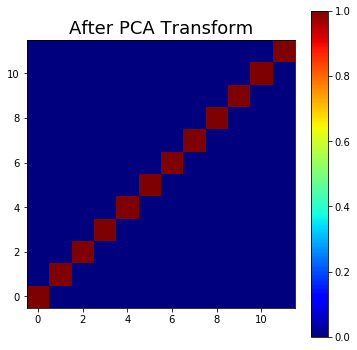

In [13]:
# Correlation matrix after pca transform
plt.figure(figsize = (6, 6))

plt.imshow(X_.corr().values, origin = 'lower', cmap = 'jet')

plt.title("After PCA Transform", size = 18)
plt.colorbar();

# TensorFlow

In [14]:
# Make the format compatible 
y_ = np.array([y_, (1 - y_)]).T  # Can use one-hot coding instead

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size = 0.25)

In [15]:
# Parameters
lr = 0.001        # Learning rate
epochs = 50000    # Training epochs
batch_size = 100
display_step = 2500

# Network parameters
n_input = 12       # Number of features
n_classes = 2      # Number of classes to predict

n_hidden_1 = 24    # First layer number of features
n_hidden_2 = 36    # 2nd layer
n_hidden_3 = 48    # 3rd layer

# tf graph input
x = tf.placeholder("float", [None, n_input])       # The None here is the batch size 
y = tf.placeholder("float", [None, n_classes])

# Store layers weight and bias
weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
            'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes])),
          }


biases = {
            'b1': tf.Variable(tf.random_normal([n_hidden_1])),
            'b2': tf.Variable(tf.random_normal([n_hidden_2])),
            'b3': tf.Variable(tf.random_normal([n_hidden_3])),
            'out': tf.Variable(tf.random_normal([n_classes])),
          }

In [16]:
def perceptron(x, weights, biases):

    """
    Multi layer perceptrom 
    """
    # First hidden layer with ReLU activation
    layer1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer1 = tf.nn.relu(layer1)  # tf.sigmoid or tf.tanh

    # Second hidden layer with ReLU activation
    layer2 = tf.add(tf.matmul(layer1, weights['h2']), biases['b2'])
    layer2 = tf.nn.relu(layer2)

    # 3rd hidden layer with ReLU activation
    layer3 = tf.add(tf.matmul(layer2, weights['h3']), biases['b3'])

    # Output layer with linear activation
    out_layer = tf.matmul(layer3, weights['out']) + biases['out']

    return out_layer


def avg_cost(X, Y):
    
    avg_cost_ = 0.0
    
    total_batch = int(len(X)/batch_size)
    X_batches = np.array_split(X, total_batch)
    Y_batches = np.array_split(Y, total_batch)

    # Loop over all batches
    for i in range(total_batch):

        batch_x, batch_y = X_batches[i], Y_batches[i]

        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})

        # Compute average loss
        avg_cost_ += c/total_batch
        
    return avg_cost_


In [31]:
# Construct model
y_pred = perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)

cost_history = []

# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
# Train
with tf.Session() as sess:
    
    sess.run(init)

    for epoch in range(epochs):

        cost_history = np.append(cost_history, avg_cost(X_train, Y_train))

        if epoch % display_step == 0:

            print("Epoch: ", "%03d" % (epoch), "cost = ", "{:.9f}".format(avg_cost(X_train, Y_train)))

    saved_path = saver.save(sess, '/home/nareg/Desktop/Data Science/Deep Learning/tfModel/my-model')


    print("Training Finished!")


Epoch:  000 cost =  84.018753052
Epoch:  2500 cost =  0.000200977
Epoch:  5000 cost =  0.000040014
Epoch:  7500 cost =  0.000010598
Epoch:  10000 cost =  0.000002989
Epoch:  12500 cost =  0.000000883
Epoch:  15000 cost =  0.000000262
Epoch:  17500 cost =  0.000000074
Epoch:  20000 cost =  0.000000018
Epoch:  22500 cost =  0.000000004
Epoch:  25000 cost =  0.000000008
Epoch:  27500 cost =  0.000001776
Epoch:  30000 cost =  0.000000199
Epoch:  32500 cost =  0.000000053
Epoch:  35000 cost =  0.000000015
Epoch:  37500 cost =  0.000000005
Epoch:  40000 cost =  0.000000002
Epoch:  42500 cost =  0.000000002
Epoch:  45000 cost =  0.000000000
Epoch:  47500 cost =  0.000000001
Training Finished!


In [34]:
# Test
with tf.Session() as sess:

    saver.restore(sess, '/home/nareg/Desktop/Data Science/Deep Learning/tfModel/my-model')

    # Test model
    correct_prediction = tf.equal(tf.argmax(y_pred, axis = 1), tf.argmax(y, axis = 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")).eval({x: X_test, y: Y_test})

    print("Accuracy: ", accuracy)

    #saved_path = saver.save(sess, './my-model', global_step=step)

    global ypred
    ypred = tf.argmax(-y_pred, 1).eval({x: X_test, y: Y_test})
    # Or result = sess.run(tf.cast(tf.argmax(-pred, axis = 1), tf.int32), feed_dict = {x: X_test, y: Y_test})
    

Accuracy:  0.8076923


In [35]:
np.mean(ypred == Y_test[:, 0])

0.8076923076923077

In [36]:
# Confusion Matrix
pd.DataFrame(confusion_matrix(result.ravel(), Y_test[:, 0]),
             index = ['R', 'M'], columns = ['R', 'M'])

,R,M
R,15,7
M,4,26


In [25]:
false_pos_rate, true_pos_rate, _ = roc_curve(result.ravel(), Y_test[:, 0])
roc_auc = auc(false_pos_rate, true_pos_rate)

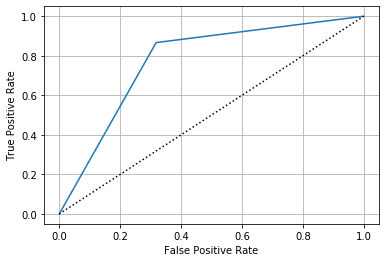

In [26]:
plt.plot(false_pos_rate, true_pos_rate, label = 'ROC curve (Area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k:')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

---

# KNN

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.33, random_state = 420)

In [20]:
X_train.shape

(139, 12)

In [1028]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [1029]:
knn.score(X_test, y_test)

0.8260869565217391

In [1030]:
y_pred_knn = knn.predict(X_test)

In [1031]:
np.mean(y_pred_knn == y_test.values)

0.8260869565217391

In [1032]:
knn.classes_

array([0, 1])

In [1033]:
pd.DataFrame(confusion_matrix(y_test, y_pred_knn), index = ['R', 'M'], columns = ['R', 'M'])

,R,M
R,30,3
M,9,27


# SVM


In [21]:
svc = SVC(C = 10.0, kernel = 'rbf', gamma = 2)
svc.fit(X_train, y_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
svc.score(X_test, y_test)

0.8260869565217391

In [23]:
y_pred_knn = svc.predict(X_test)

In [24]:
pd.DataFrame(confusion_matrix(y_test, y_pred_knn), index = ['R', 'M'], columns = ['R', 'M'])

,R,M
R,25,8
M,4,32
